In [151]:
import torch
import pandas as pd
from torch.autograd import Variable
import numpy as np 
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [125]:
df = pd.read_csv("/content/diabetes.csv",dtype=float,delimiter=',')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [126]:
def check_df(dataframe, head=5, tail = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head ######################")
    print(dataframe.head(head))
    print("##################### Tail ######################")
    print(dataframe.tail(tail))
    print("##################### NA ########################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [127]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                     float64
dtype: object
##################### Head ######################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      0.0  33.6   
1          1.0     85.0           66.0           29.0      0.0  26.6   
2          8.0    183.0           64.0            0.0      0.0  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          0.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction   Age  Outcome  
0                     0.6

In [128]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [129]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [130]:
cat_cols

['Outcome']

In [131]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [132]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


In [133]:
df[cat_cols].describe()

,Outcome
count,768.000000
mean,0.348958
std,0.476951
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [134]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

     Outcome      Ratio
0.0      500  65.104167
1.0      268  34.895833
##########################################


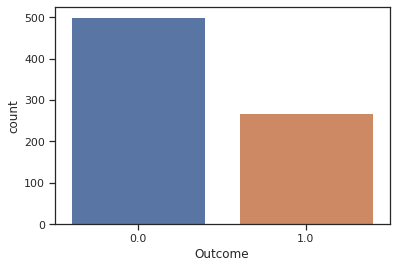

In [135]:
cat_summary(df, "Outcome", True)

In [136]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

                          count        mean         std     min        5%  \
Pregnancies               768.0    3.845052    3.369578   0.000   0.00000   
Glucose                   768.0  120.894531   31.972618   0.000  79.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  38.70000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  21.80000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.14035   
Age                       768.0   33.240885   11.760232  21.000  21.00000   

                             10%      20%      30%       40%       50%  \
Pregnancies                0.000   1.0000    1.000    2.0000    3.0000   
Glucose                   85.000  95.0000  102.000  109.0000  117.0000   
BloodPressure             54.000  60.0000   64.000   68.0000   72.0000   
SkinThickn

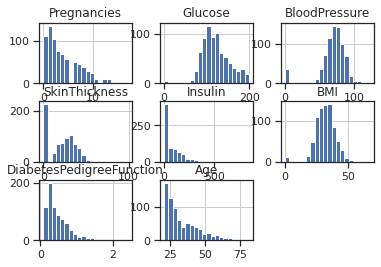

In [137]:
num_summary(df, num_cols, True)

In [138]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0.0         3.298000
1.0         4.865672


            Glucose
Outcome            
0.0      109.980000
1.0      141.257463


         BloodPressure
Outcome               
0.0          68.184000
1.0          70.824627


         SkinThickness
Outcome               
0.0          19.664000
1.0          22.164179


            Insulin
Outcome            
0.0       68.792000
1.0      100.335821


               BMI
Outcome           
0.0      30.304200
1.0      35.142537


         DiabetesPedigreeFunction
Outcome                          
0.0                      0.429734
1.0                      0.550500


               Age
Outcome           
0.0      31.190000
1.0      37.067164




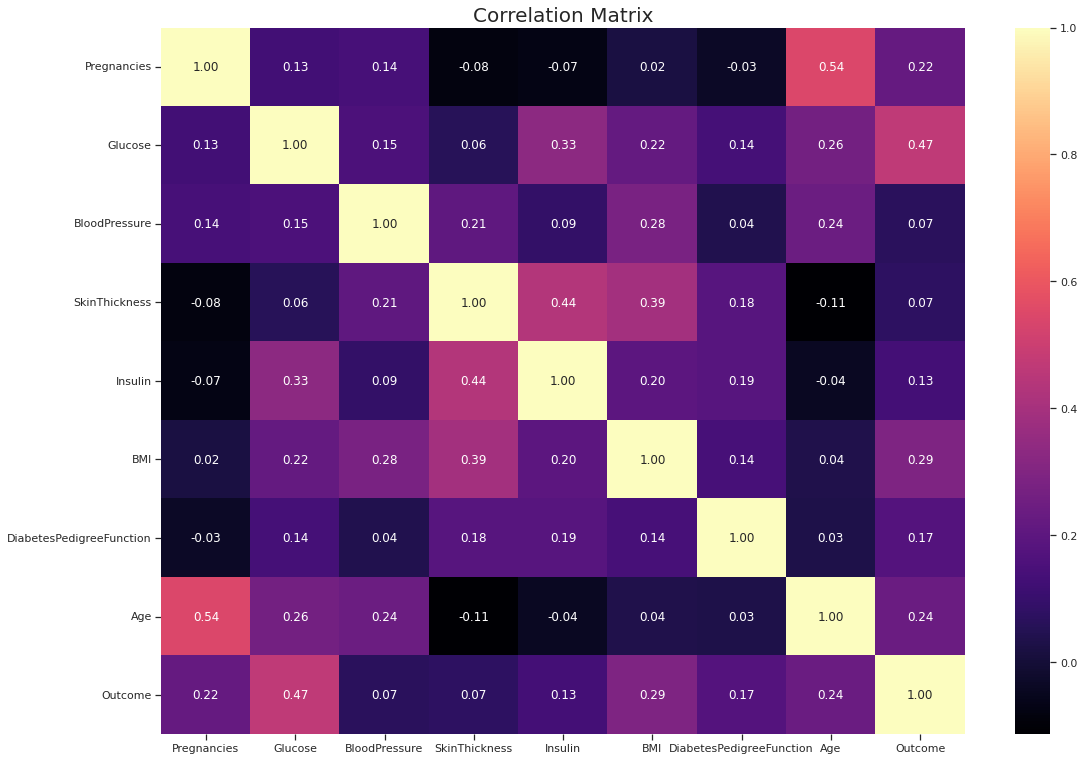

In [139]:
df.corr()

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

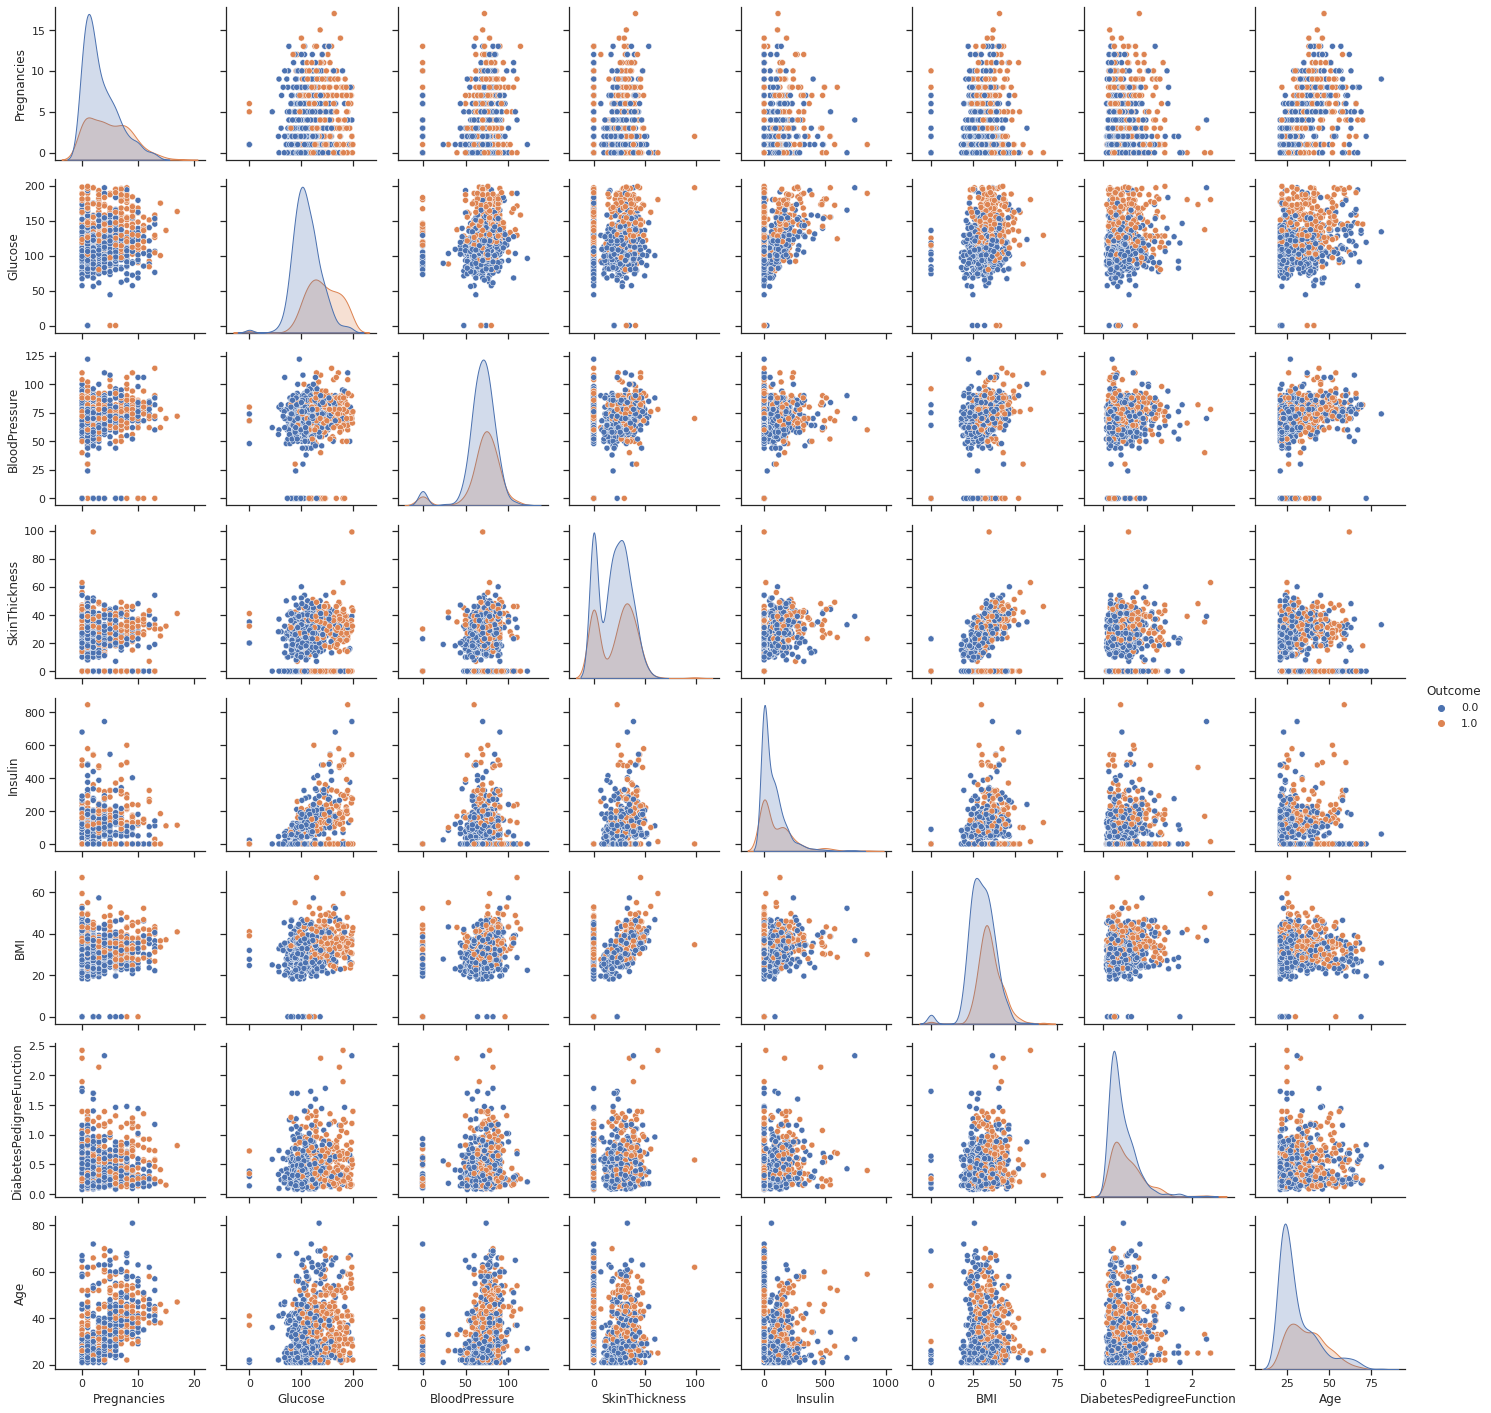

In [140]:
def pairplot(dataset, target_column):
    sns.set(style="ticks")
    sns.pairplot(dataset, hue=target_column)
    plt.show()

pairplot(df, 'Outcome')

In [164]:
x = df.drop('Outcome',axis=1)
y=df['Outcome']
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0


In [165]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y , test_size =0.2,random_state=0)

In [166]:
x_train=torch.FloatTensor(x_train.values)
x_test=torch.FloatTensor(x_test.values)
y_train=torch.LongTensor(y_train.values)
y_test=torch.LongTensor(y_test.values)

In [203]:
class ANN_model(nn.Module):
    def __init__(self,input_features=8,hidden1=20, hidden2=10,out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features,hidden1)
        self.f_connected2 = nn.Linear(hidden1,hidden2)
        self.out = nn.Linear(hidden2,out_features)
        
    def forward(self,x):
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = self.out(x)
        return x

In [206]:
torch.manual_seed(20)
model = ANN_model()

In [207]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [208]:
epochs=1000
final_losses=[]
for i in range(epochs):
    i= i+1
    y_pred = model.forward(x_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss)
    if i % 10 == 1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 7.187566757202148
Epoch number: 11 and the loss : 0.8532984256744385
Epoch number: 21 and the loss : 0.716244637966156
Epoch number: 31 and the loss : 0.6571372747421265
Epoch number: 41 and the loss : 0.6171260476112366
Epoch number: 51 and the loss : 0.6081922054290771
Epoch number: 61 and the loss : 0.6015171408653259
Epoch number: 71 and the loss : 0.5953478813171387
Epoch number: 81 and the loss : 0.5914437770843506
Epoch number: 91 and the loss : 0.5878034830093384
Epoch number: 101 and the loss : 0.5838866829872131
Epoch number: 111 and the loss : 0.5791389346122742
Epoch number: 121 and the loss : 0.5727564692497253
Epoch number: 131 and the loss : 0.5666334629058838
Epoch number: 141 and the loss : 0.5580757260322571
Epoch number: 151 and the loss : 0.5513749122619629
Epoch number: 161 and the loss : 0.5447184443473816
Epoch number: 171 and the loss : 0.5398930311203003
Epoch number: 181 and the loss : 0.5355622172355652
Epoch number: 191 and the

In [209]:
predictions = []
with torch.no_grad():
    for i,data in enumerate(x_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())
        

Text(30.5, 0.5, 'Predicted')

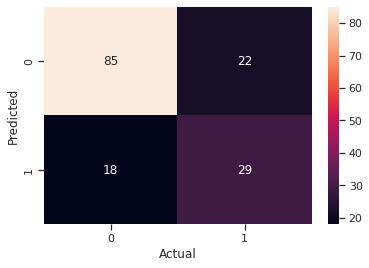

In [210]:
cm = confusion_matrix(y_test,predictions)
cm
sns.heatmap(cm,annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [211]:
score = accuracy_score(y_test , predictions)
print(score)

0.7402597402597403
